In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import geopandas as gpd
import heapq
import random
import timeit

from shapely.geometry import *

import sys
sys.path.append('./../exploration') # this is where the magic is going down
sys.path.append('./..')

from intersections_and_roads import *
from search import *
%matplotlib inline

In [2]:
# Read in the geolocation data
intersections = gpd.read_file('../cambridgegis_data_trans/Intersections/TRANS_Intersections.topojson')
street_centerline = gpd.read_file('../cambridgegis_data_trans/Street_Centerlines/TRANS_Centerlines.topojson')
intersection_graph, connection_dict = build_intersection_graph(intersections=intersections, street_centerline=street_centerline)

In [3]:
## add costs of streets to connection_dic:

bike_accidents = pd.read_csv('./../exploration/bicycle_crashes.csv')
bike_crashes_per_street = bike_accidents.groupby(['Street_ID'], as_index=False).size().reset_index()
bike_crashes_per_street.rename(index=str, inplace=True, columns={0: 'num_accidents'})

In [4]:
bike_crashes_per_street.head()

,Street_ID,num_accidents
0,Aberdee_Ave_1,2
1,Aberdee_Ave_2,1
2,Albany_St_1,1
3,Albany_St_2,2
4,Albany_St_4,8


In [5]:
# add num accidents to each street id
for street in bike_crashes_per_street.itertuples():
    if connection_dict.get(street[1], None):
        connection_dict[street[1]].add_accidents(street[2])

In [6]:
# randomly select a start and an end point on the graph for test
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]


In [7]:
# search the graph
route = a_star_search(start, end, intersection_graph, connection_dict, get_road_cost)
safe_route = a_star_search(start, end, intersection_graph, connection_dict, get_safe_road_cost)

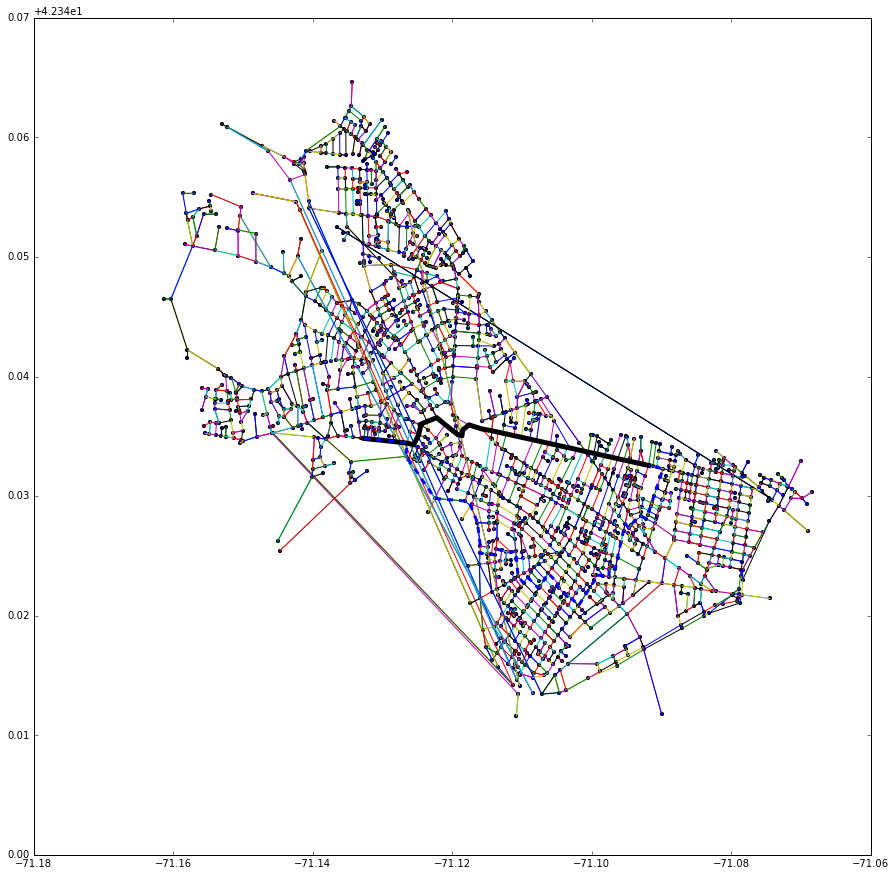

In [8]:
plot_graph(intersection_graph, connection_dict, [route['nodes']], [safe_route['nodes']])

In [9]:
p1 = intersection_graph[np.random.choice(intersection_graph.keys())]
p2 = intersection_graph[np.random.choice(intersection_graph.keys())]
p3 = intersection_graph[np.random.choice(intersection_graph.keys())]
p4 = intersection_graph[np.random.choice(intersection_graph.keys())]

centroid = simulated_annealing_b(intersection_graph,
                                 connection_dict,
                                 get_road_cost,
                                 null_heuristic,
                                 starting_points=[p1,p2,p3])

In [ ]:
routes = []
connections = []
# fig, ax = plt.subplots(1,1, figsize=(15, 15))
for start in [p1,p2,p3,p4]:
    route = a_star_search(start, centroid, intersection_graph, connection_dict, get_road_cost)
    routes.append(route['nodes'])
    connections.append(route['connections'])

plot_graph(intersection_graph, connection_dict, routes, [])

In [ ]:
# timing for comparing heuristics down the line
def test():
#     start = intersection_graph[np.random.choice(intersection_graph.keys())]
#     end = intersection_graph[np.random.choice(intersection_graph.keys())]
    a_star_search(start, end, intersection_graph)

timeit.timeit("test()", setup="from __main__ import *", number=10)

Deal with elevation:

In [6]:
elevation = gpd.read_file('./../cambridgegis_data_trans/SpotElevations.geojson')
elevation.head(2)

,ELEV,TYPE,geometry
0,28.78,SPOT-RD-INT,POINT Z (-71.1199704241649 42.39099096795356 2...
1,29.90,SPOT-RD-INT,POINT Z (-71.11879996393426 42.39131624347542 ...


In [7]:
def elev(node):
#     print node
    point = Point(node.get_x_y()[0], node.get_x_y()[1])
    dist = [point.distance(elev_point) for elev_point in elevation['geometry']]
    clostest = np.argmin(dist)
    return elevation.iloc[clostest]['ELEV']

In [8]:
for node in intersection_graph.values():
    node.set_elevation(elev(node))

In [9]:
intersection_graph['1613'].get_elevation()

7.8300000000000001

In [10]:
for connection in connection_dict:
#     print intersection_graph[connection_dict[connection].source].get_elevation()
    source_elev = intersection_graph[connection_dict[connection].source].get_elevation()
    target_elev = intersection_graph[connection_dict[connection].target].get_elevation()
    connection_dict[connection].set_delta_elevation(target_elev - source_elev)

In [16]:
np.max([node.get_elevation() for node in intersection_graph.values()])

71.989999999999995

In [17]:
intersections.head(2)

,EditDate,GlobalID,IntersectingStreetCount,Intersection,NodeNumber,P_X,P_Y,geometry,id
0,None,{D1E59B72-36DC-4E6B-9950-B9260BAA807C},2,Cardinal Medeiros Ave & James Way,1381,767108.65,2960261.64,POINT (-71.08945606491686 42.37037471967096),1174
1,None,{D18D1979-4869-4E5A-9D14-DC74ECDB7CBB},NaN,None,118,755424.60,2969559.46,POINT (-71.13254779801892 42.39603508437763),131


In [20]:
street_centerline.head(2).columns

Index([               u'Alias',            u'Direction',
                   u'EditDate',             u'FromNode',
                   u'GlobalID',               u'L_From',
                       u'L_To',                u'Label',
                  u'MajorRoad', u'Potentail_Range_Done',
           u'Potential_L_From',       u'Potential_L_To',
           u'Potential_R_From',       u'Potential_R_To',
                   u'ROADWAYS',               u'R_From',
                       u'R_To',          u'Restriction',
                     u'Street',            u'Street_ID',
                u'Street_Name',          u'Street_Type',
                     u'ToNode',             u'ZIP_Left',
                  u'ZIP_Right',             u'geometry',
                         u'id'],
      dtype='object')